# F4 Pre Trained Autoencoders Experiments

From:

- https://github.com/CompVis/latent-diffusion#pretrained-autoencoding-models


### KL Autoencoder

In [111]:
import os
import wget
import zipfile

import numpy as np

from PIL import Image

import torchvision.transforms as transforms
import torch

from ldm.models.autoencoder import AutoencoderKL

In [112]:
def download_pre_trained_ae(url, output_dir):
    if os.path.exists(output_dir):
        print("Used cache")
    else:
        filename = wget.download(url)

        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

        if os.path.exists(filename):
            os.remove(filename)

In [113]:
MODEL_DIR = './pretrained_models/klf4'

download_pre_trained_ae("https://ommer-lab.com/files/latent-diffusion/kl-f4.zip", MODEL_DIR)

Used cache


In [114]:
ddconfig = {
    "double_z": True,
    "z_channels": 3,
    "resolution": 256,
    "in_channels": 3,
    "out_ch": 3,
    "ch": 128,
    "ch_mult": [1,2,4],
    "num_res_blocks": 2,
    "attn_resolutions": [],
    "dropout": 0.0
}
lossconfig = {
      "target": "ldm.modules.losses.LPIPSWithDiscriminator",
      "params": {
        "disc_start": 50001,
        "kl_weight": 1.0e-06,
        "disc_weight": 0.5
      }
}
embed_dim = 3

pl_sd = torch.load(f"{MODEL_DIR}/model.ckpt") #, map_location="cpu"

model = AutoencoderKL(ddconfig, lossconfig, embed_dim)

model.load_state_dict(pl_sd["state_dict"] ,strict=False)
model.cuda()
# model.eval()


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
  

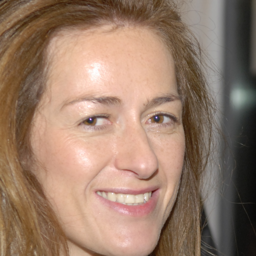

In [115]:
img = Image.open("/data/ffhq/images256x256/40058_256.png")
img.show()

In [116]:
# img = Image.open("/data/ffhq/images256x256/28154_256.png")
# img.show()

In [117]:
# img = Image.open("imagenet1.png")
# img

In [118]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = transform(img).to(model.device).unsqueeze(0)

In [119]:
def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.) / 2.
    x = x.permute(1, 2, 0).numpy()
    x = (255 * x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

In [120]:
output = model(img)

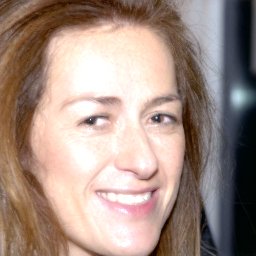

In [121]:
x = output[0]

if len(x.shape) == 4:
    gen_img = custom_to_pil(x[0, ...])
elif len(x.shape) == 3:
    gen_img = custom_to_pil(x)
else:
    gen_img = None

gen_img

In [122]:
output = model.encoder(img)

In [123]:
print(output.min())
print(output.max())
output.shape

tensor(-33.7263, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.4827, device='cuda:0', grad_fn=<MaxBackward1>)


torch.Size([1, 6, 64, 64])

In [124]:
np.save('latent_z_test.npy', output.cpu().detach().numpy())
latent_z = torch.Tensor(np.load('latent_z_test.npy'))
latent_z.shape

torch.Size([1, 6, 64, 64])

In [125]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0,0,0,0,0,0], std=[128, 128, 128, 128, 128, 128])
])

normalised = transform(latent_z)
print(normalised.min())
print(normalised.max())

tensor(-0.2635)
tensor(0.3553)
